In [60]:
# libs
import pandas as pd
import numpy as np
from datetime import datetime
import os

# bar plots
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
# today's date string for file namine automation
today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
print(today_date_str)

_2024-02-26.csv


In [62]:
# cocncat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"

# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

1266 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,...,Relative Volume 1 week,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Beta 1 year,Beta 3 years,Beta 5 years
0,MSFT,Microsoft Corporation,NASDAQ,3034961571473.887,USD,408.4500,USD,1.06,USD,0.258322,...,0.02686712,0.945383,1.597040,1.517290,409.636667,36.94140205,Technology Services,0.954249,1.0329885,0.8991026
1,NVDA,NVIDIA Corporation,NASDAQ,1975724957160.079,USD,790.2900,USD,8.85,USD,1.122854,...,0.05753337,2.727202,6.121646,3.583778,793.933300,66.20784987,Electronic Technology,1.777562,2.2734668,1.6840769
2,AMZN,"Amazon.com, Inc.",NASDAQ,1814259997850.8013,USD,174.6600,USD,0.71,USD,0.405737,...,0.03263947,1.031105,1.852445,1.897577,175.200000,60.44435216,Retail Trade,1.122218,1.3340302,1.142365
3,BRK.B,Berkshire Hathaway Inc. New,NYSE,913421737403.8116,USD,420.8829,USD,4.38,USD,1.049806,...,0.123855,3.044307,1.530185,1.242365,423.560967,11.97040128,Finance,0.677712,0.86781585,0.8809025
4,BRK.A,Berkshire Hathaway Inc.,NYSE,912137843061.4086,USD,633559.9900,USD,7126.82,USD,1.133166,...,0.26540262,2.869860,1.681073,1.309302,637199.662933,12.01278649,Finance,0.653694,0.85174525,0.88295174


In [63]:
# # first 10 rows df
# trading_view_raw_df_testing = trading_view_raw_df.head(10)
# # save to csv
# trading_view_raw_df_testing.to_csv('trading_view_raw_data/tv_screen_gap-up_testing.csv', index=False)
# # make sure data is there at least
# print(len(trading_view_raw_df_testing.index))

# # print test df
# trading_view_raw_df_testing

In [64]:
# # baseline raw cols from trading view initial filter
# features_raw_all = trading_view_raw_df.columns
# # convert to list
# features_raw_all = features_raw_all.tolist()
# # look at the trading view columns
# print(features_raw_all)

In [65]:
"""
define function -> add new column and marketCapType based on 'Market capitalization' column

criteria (6 groupings):
200B and above = 'Titans' - 1
10B to 200B = 'Large caps' - 2
2B to 10B = 'Midlers' - 3
300M to 2B = 'Small caps' - 4
300m and below = 'Micro caps' - 5
50m and below = 'Shrimp' - 6

"""

"\ndefine function -> add new column and marketCapType based on 'Market capitalization' column\n\ncriteria (6 groupings):\n200B and above = 'Titans' - 1\n10B to 200B = 'Large caps' - 2\n2B to 10B = 'Midlers' - 3\n300M to 2B = 'Small caps' - 4\n300m and below = 'Micro caps' - 5\n50m and below = 'Shrimp' - 6\n\n"

In [66]:
def categorize_market_cap(df):
    # Convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    
    # Define the conditions for each market cap category using regular number notation
    conditions = [
        # Titans
        (df['Market capitalization'] >= 200000000000),  # 200 billion and above

        #Large Cap
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),  # 10 billion to 200 billion
        
        # Midlers
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),  # 2 billion to 10 billion
        
        # Small Cap
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000),  # 300 million to 2 billion
       
        # Micro Cap
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),  # 300 million and below (excluding 50 million and below)
       
        # Shrimp
        (df['Market capitalization'] <= 50000000)  # 50 million and below
    ]
    
    # Define the category names corresponding to each condition
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    
    # Use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df


In [67]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,...,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Beta 1 year,Beta 3 years,Beta 5 years,marketCapType
0,MSFT,Microsoft Corporation,NASDAQ,3.034962e+12,USD,408.4500,USD,1.06,USD,0.258322,...,0.945383,1.597040,1.517290,409.636667,36.94140205,Technology Services,0.954249,1.0329885,0.8991026,Titans
1,NVDA,NVIDIA Corporation,NASDAQ,1.975725e+12,USD,790.2900,USD,8.85,USD,1.122854,...,2.727202,6.121646,3.583778,793.933300,66.20784987,Electronic Technology,1.777562,2.2734668,1.6840769,Titans
2,AMZN,"Amazon.com, Inc.",NASDAQ,1.814260e+12,USD,174.6600,USD,0.71,USD,0.405737,...,1.031105,1.852445,1.897577,175.200000,60.44435216,Retail Trade,1.122218,1.3340302,1.142365,Titans
3,BRK.B,Berkshire Hathaway Inc. New,NYSE,9.134217e+11,USD,420.8829,USD,4.38,USD,1.049806,...,3.044307,1.530185,1.242365,423.560967,11.97040128,Finance,0.677712,0.86781585,0.8809025,Titans
4,BRK.A,Berkshire Hathaway Inc.,NYSE,9.121378e+11,USD,633559.9900,USD,7126.82,USD,1.133166,...,2.869860,1.681073,1.309302,637199.662933,12.01278649,Finance,0.653694,0.85174525,0.88295174,Titans


In [68]:
# # check for NaNs
# print(trading_view_raw_df.isna().sum())

In [69]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
# get simple count of NaNs total. should be 0
print(f'NaNs = {tv_df.isna().sum().sum()}')

# if there are no NaNs, print "No NaNs in DataFrame! Success!", else print the NaN count and "There are x NaNs in DataFrame, check your code dumb dumb!"
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")


NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [70]:
mc_groups = trading_view_raw_df['marketCapType'].value_counts().reset_index()
mc_groups.columns = ['marketCapType', 'count']  # Rename columns for clarity

# Calculate percentage for each market cap type and add it to the DataFrame
mc_groups['percentage'] = (mc_groups['count'] / mc_groups['count'].sum()) * 100

# Display the enhanced DataFrame
mc_groups

,marketCapType,count,percentage
0,Small caps,287,22.669826
1,Shrimp,249,19.668246
2,Midlers,245,19.352291
3,Large caps,224,17.693523
4,Micro caps,221,17.456556
5,Titans,26,2.053712
6,Undefined,14,1.105845


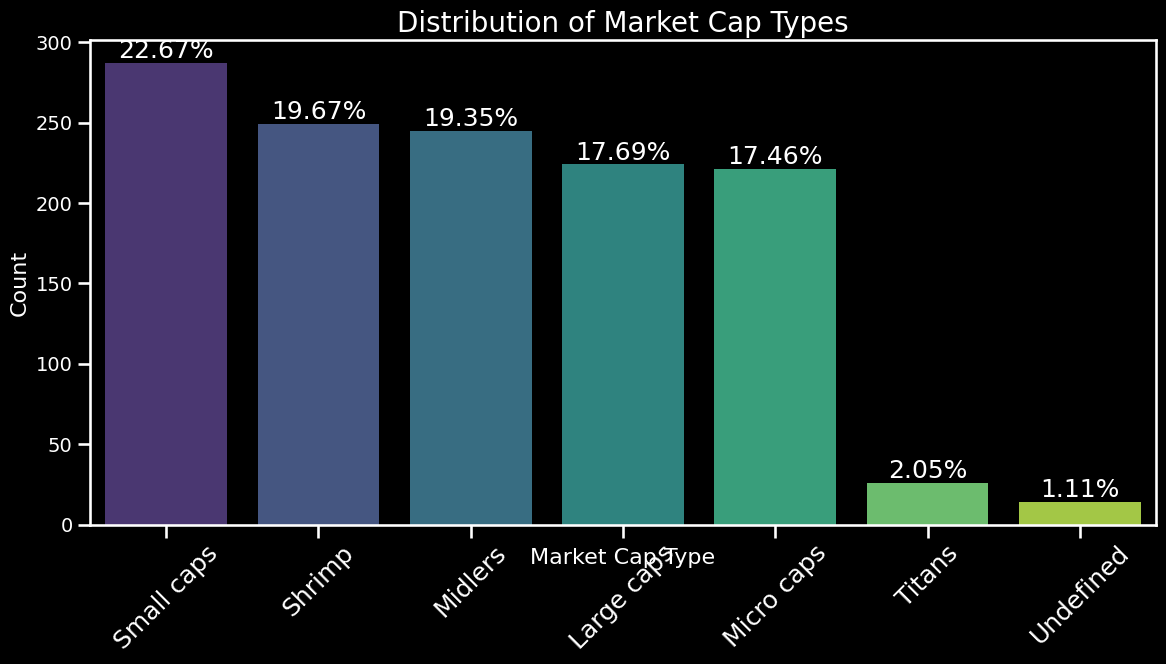

In [71]:
# Set dark mode for plotting
plt.style.use('dark_background')
sns.set_context('talk')  # Larger fonts and figures

# Create a bar chart with a modern and professional look
plt.figure(figsize=(12, 7))
# Assign 'marketCapType' to both x and hue, and explicitly disable the legend
barplot = sns.barplot(data=mc_groups, x='marketCapType', y='count', hue='marketCapType', palette='viridis', legend=False)

# After plotting, you can disable the legend that comes with using 'hue'
plt.legend([],[], frameon=False)

# Customize the plot with percentage labels
for index, row in mc_groups.iterrows():
    # Adjust the positioning based on your data for clarity
    barplot.text(index, row['count'], f'{row["percentage"]:.2f}%', color='white', ha="center", va="bottom")

# Add marketCapType labels underneath the bars
for index, row in mc_groups.iterrows():
    barplot.text(index, -10, row['marketCapType'], color='white', ha="center", va="top", rotation=45)

plt.title('Distribution of Market Cap Types', fontsize=20, color='white')
plt.xlabel('Market Cap Type', fontsize=16, color='white')
plt.ylabel('Count', fontsize=16, color='white')
plt.xticks(rotation=45, fontsize=14, color='white')
plt.yticks(fontsize=14, color='white')

# Remove x-axis labels to avoid redundancy due to hue
barplot.set_xticklabels([])

# Show the plot
plt.tight_layout()
plt.show()

In [72]:
# print length of df
print(len(tv_df.index))
# print sample head
tv_df.sample(10)

1252


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,...,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Beta 1 year,Beta 3 years,Beta 5 years,marketCapType
1107,STRC,Sarcos Technology and Robotics Corporation,NASDAQ,1.783707e+07,USD,0.6900,USD,0.1056,USD,17.880122,...,22.671493,11.102505,12.257147,0.700833,-,Producer Manufacturing,3.112455,2.4067647,2.4067647,Shrimp
1010,AGMH,AGM Group Holdings Inc.,NASDAQ,4.770226e+07,USD,1.8100,USD,0.0600,USD,3.550296,...,21.052632,14.722318,10.058204,1.856667,3.37120507,Technology Services,0.008849,1.4558562,1.0258027,Shrimp
483,ARDX,"Ardelyx, Inc.",NASDAQ,2.145365e+09,USD,9.2200,USD,0.0100,USD,0.115207,...,9.149184,8.582577,5.534149,9.055000,-,Health Technology,2.719618,0.634882,0.914344,Midlers
407,DNP,"DNP Select Income Fund, Inc.",NYSE,3.220710e+09,USD,8.8710,USD,0.0300,USD,0.338219,...,0.395034,1.354581,1.330471,8.875333,-,Miscellaneous,0.332329,0.3298001,0.47739473,Midlers
744,ITOS,"iTeos Therapeutics, Inc.",NASDAQ,3.929189e+08,USD,10.9800,USD,0.0050,USD,0.046970,...,4.347826,7.274661,4.949208,10.866667,-,Health Technology,1.138131,0.6447607,1.1404684,Small caps
913,ANVS,"Annovis Bio, Inc.",NYSE,1.010394e+08,USD,9.5501,USD,0.4100,USD,4.124748,...,4.736842,7.330616,8.335024,9.666700,-,Health Technology,0.499644,1.2493923,1.6483157,Micro caps
1095,PRST,"Presto Automation, Inc.",NASDAQ,2.044037e+07,USD,0.2530,USD,0.0014,USD,0.538462,...,5.160000,14.680664,18.496613,0.255300,-,Technology Services,-0.805330,1.6106548,1.6106548,Shrimp
557,TVGN,Tevogen Bio Holdings Inc.,NASDAQ,1.291973e+09,USD,7.8897,USD,0.2450,USD,3.340150,...,7.794973,19.071991,38.680932,7.909800,114.67587209,Finance,-1.055318,-0.06405178,-0.06405178,Small caps
903,DNMR,"Danimer Scientific, Inc.",NYSE,1.184017e+08,USD,1.1604,USD,0.0200,USD,1.869159,...,9.345794,14.321509,12.529784,1.133467,-,Process Industries,2.627381,1.1856891,1.1666379,Micro caps
936,WKHS,"Workhorse Group, Inc.",NASDAQ,8.478859e+07,USD,0.3250,USD,0.0135,USD,4.708755,...,19.112742,24.552480,10.245088,0.322933,-,Consumer Durables,2.436246,1.8984073,2.4705076,Micro caps


In [73]:
# show unique values for 'marketCapType'
print(tv_df['marketCapType'].unique())
print()
# get tv_df columns
print(tv_df.columns)

['Titans' 'Large caps' 'Midlers' 'Small caps' 'Micro caps' 'Shrimp']

Index(['Symbol', 'Description', 'Exchange', 'Market capitalization',
       'Market capitalization - Currency', 'Price', 'Price - Currency',
       'Pre-market Change', 'Pre-market Change - Currency',
       'Pre-market Change %', 'Pre-market Gap %', 'Float shares outstanding',
       'Volume 1 day', 'Relative Volume 1 day', 'Average Volume 10 days',
       'Pre-market Volume', 'Relative Volume at Time',
       'Relative Volume at Time.1', 'Volume 1 week', 'Relative Volume 1 week',
       'Volatility 1 day', 'Volatility 1 week', 'Volatility 1 month',
       'Volume Weighted Average Price 1 day', 'Price to earnings ratio',
       'Sector', 'Beta 1 year', 'Beta 3 years', 'Beta 5 years',
       'marketCapType'],
      dtype='object')


In [74]:
"""
was stuck a little here. wanted to write the code as professional as possible.
caught myself using to many slicing and needed to create more scalable and tweakable stock filter paremeters.

# market cap dataframes
# titans_df = tv_df[tv_df['marketCapType'] == 'Titans']
# large_caps_df = tv_df[tv_df['marketCapType'] == 'Large caps']
# midlers_df = tv_df[tv_df['marketCapType'] == 'Midlers']
# small_caps_df = tv_df[tv_df['marketCapType'] == 'Small caps']
# micro_caps_df = tv_df[tv_df['marketCapType'] == 'Micro caps']
# shrimp_df = tv_df[tv_df['marketCapType'] == 'Shrimp']

# # EXECUTE change percent filter
# titans_df = change_percent_filter(titans_df, .005)
# large_caps_df = change_percent_filter(large_caps_df, .01)
# midlers_df = change_percent_filter(midlers_df, .02)
# small_caps_df = change_percent_filter(small_caps_df, .03)
# micro_caps_df = change_percent_filter(micro_caps_df, .04)
# shrimp_df = change_percent_filter(shrimp_df, .05)
"""

"\nwas stuck a little here. wanted to write the code as professional as possible.\ncaught myself using to many slicing and needed to create more scalable and tweakable stock filter paremeters.\n\n# market cap dataframes\n# titans_df = tv_df[tv_df['marketCapType'] == 'Titans']\n# large_caps_df = tv_df[tv_df['marketCapType'] == 'Large caps']\n# midlers_df = tv_df[tv_df['marketCapType'] == 'Midlers']\n# small_caps_df = tv_df[tv_df['marketCapType'] == 'Small caps']\n# micro_caps_df = tv_df[tv_df['marketCapType'] == 'Micro caps']\n# shrimp_df = tv_df[tv_df['marketCapType'] == 'Shrimp']\n\n# # EXECUTE change percent filter\n# titans_df = change_percent_filter(titans_df, .005)\n# large_caps_df = change_percent_filter(large_caps_df, .01)\n# midlers_df = change_percent_filter(midlers_df, .02)\n# small_caps_df = change_percent_filter(small_caps_df, .03)\n# micro_caps_df = change_percent_filter(micro_caps_df, .04)\n# shrimp_df = change_percent_filter(shrimp_df, .05)\n"

In [75]:
"""
moved forward with more pro code. 

still fucked tho.
"""

'\nmoved forward with more pro code. \n\nstill fucked tho.\n'

In [76]:
# drop undefined
tv_df = tv_df[tv_df['marketCapType'] != 'Undefined']

mc_groups2 = tv_df['marketCapType'].value_counts().reset_index()
mc_groups2.columns = ['marketCapType', 'count']  # Rename columns for clarity

# calculate percentage for each market cap type and add it to the DataFrame
mc_groups2['percentage'] = (mc_groups2['count'] / mc_groups2['count'].sum()) * 100

mc_groups2
print(mc_groups2)


  marketCapType  count  percentage
0    Small caps    287   22.923323
1        Shrimp    249   19.888179
2       Midlers    245   19.568690
3    Large caps    224   17.891374
4    Micro caps    221   17.651757
5        Titans     26    2.076677


In [77]:
# 1/3 #### CONFIG DATA SECTION ####
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.005,  # 0.5% for Titans
        "float_shares_outstanding_threshold": 500000000,  # 500 million shares
        "relative_volume_threshold": 1.5
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.01,  # 1% for Large caps
        "float_shares_outstanding_threshold": 100000000,  # 100 million shares
        "relative_volume_threshold": 1.4
    },
    "Mid caps": {
        "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0
    }
}

# 2/3 #### CORE FUNCTIONS ####
def filter_by_pre_market_change(df, change_pct_threshold):
    """Filter stocks by pre-market change percentage."""
    return df[df['Pre-market Change %'] >= change_pct_threshold]

def filter_by_float_shares(df, float_shares_threshold):
    """Filter stocks by float shares outstanding."""
    # create a copy to safely modify without affecting the original DataFrame
    modified_df = df.copy()
    modified_df['Float shares outstanding'] = pd.to_numeric(modified_df['Float shares outstanding'], errors='coerce')
    return modified_df[modified_df['Float shares outstanding'] <= float_shares_threshold]

def filter_by_relative_volume(df, relative_volume_threshold):
    """Filter stocks by relative volume."""
    return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

# 3/3 #### WRAPPER FUNCTION ####
def screen_stocks_by_category(df, category):
    """Screen stocks based on their market cap category."""
    # 3a. Get the configuration for the specified category
    config = criteria_config.get(category, {})
    pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
    float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
    relative_volume_threshold = config.get("relative_volume_threshold", 0)
    # 3b. Apply the filters
    filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
    filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
    filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
    # 3c. Return the filtered DataFrame
    return filtered_df

In [78]:
#EXECUTE
tv_L2_df = pd.DataFrame()
categories = tv_df['marketCapType'].unique()

for category in categories:
    category_df = tv_df[tv_df['marketCapType'] == category]
    screened_df = screen_stocks_by_category(category_df, category)
    tv_L2_df = pd.concat([tv_L2_df, screened_df])

# Display results
print(f'Original DataFrame length: {len(tv_df.index)}')
print(f'Number of rows removed: {len(tv_df.index) - len(tv_L2_df.index)}')
print(f'NEW DataFrame length: {len(tv_L2_df.index)}')
# Use 'display' for Jupyter notebooks to format DataFrame; otherwise, use print(final_results.sample(10).to_string())
display(tv_L2_df.sample(5))

Original DataFrame length: 1252
Number of rows removed: 1011
NEW DataFrame length: 241


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,...,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Beta 1 year,Beta 3 years,Beta 5 years,marketCapType
296,GNRC,Generac Holdings Inc.,NYSE,6.722138e+09,USD,111.535,USD,0.21,USD,0.186187,...,2.257480,3.580997,3.773574,111.458333,33.85593735,Producer Manufacturing,2.712226,1.946068,1.45039,Midlers
374,AXSM,"Axsome Therapeutics, Inc.",NASDAQ,3.758751e+09,USD,79.380,USD,0.21,USD,0.266025,...,1.490066,6.142059,3.203585,79.196667,-,Health Technology,1.002538,0.38673297,1.1986682,Midlers
462,PSEC/PA,Prospect Capital Corporation 5.35% Series A Fi...,NYSE,2.376288e+09,USD,18.450,USD,0.35,USD,1.955307,...,3.015351,3.432681,2.040878,18.380000,-,Finance,1.014305,0.52589417,0.52589417,Midlers
370,JOBY,"Joby Aviation, Inc.",NYSE,3.857610e+09,USD,5.540,USD,0.04,USD,0.738007,...,4.018692,7.836057,5.328659,5.485000,-,Electronic Technology,3.182885,2.147025,2.1137888,Midlers
415,PRKS,United Parks & Resorts Inc.,NYSE,3.006648e+09,USD,47.020,USD,0.51,USD,1.084876,...,1.479417,2.979580,2.711895,46.996667,12.46289228,Consumer Services,1.389642,1.2834704,1.8158644,Midlers


In [ ]:
# print(tv_L2_df.columns)

In [ ]:
# # look at relative volume 1 day
# tv_L2_df.loc[:, ['Symbol','Description', 'Relative Volume 1 day']]

In [ ]:
# print(len(tv_L2_df.index))
# tv_L2_df.loc[tv_L2_df['Relative Volume 1 day'] >= 1.0]


In [82]:
# sort descending by change %
# another df and  / or chart market cap representations

# i think you need to go back and filter this shit down more
# chart could be nice to reference, really just need something i can see easy while working

# re-index this shit and keep it clean
# don't be a dumbass and have any data leakage

# you can do a lot more with changes on different very short term time frames

# do i need a calculation for pre-market price????

# you need to figure out implied volatility and noise vs. signal.

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [83]:
# # market cap dataframes
# titans_df = tv_df[tv_df['marketCapType'] == 'Titans']
# large_caps_df = tv_df[tv_df['marketCapType'] == 'Large caps']
# midlers_df = tv_df[tv_df['marketCapType'] == 'Midlers']
# small_caps_df = tv_df[tv_df['marketCapType'] == 'Small caps']
# micro_caps_df = tv_df[tv_df['marketCapType'] == 'Micro caps']
# shrimp_df = tv_df[tv_df['marketCapType'] == 'Shrimp']

# # EXECUTE change percent filter
# titans_df = change_percent_filter(titans_df, .005)
# large_caps_df = change_percent_filter(large_caps_df, .01)
# midlers_df = change_percent_filter(midlers_df, .02)
# small_caps_df = change_percent_filter(small_caps_df, .03)
# micro_caps_df = change_percent_filter(micro_caps_df, .04)
# shrimp_df = change_percent_filter(shrimp_df, .05)

In [84]:
# def change_percent_filter(df, change_percent_min=None ):                               
#     if change_percent_min is not None:
#         df = df[df['Pre-market Change %'] >= change_percent_min]
#     return df  

In [85]:
# # EXECUTE change percent filter
# titans_df = change_percent_filter(titans_df, .005)
# large_caps_df = change_percent_filter(large_caps_df, .01)
# midlers_df = change_percent_filter(midlers_df, .02)
# small_caps_df = change_percent_filter(small_caps_df, .03)
# micro_caps_df = change_percent_filter(micro_caps_df, .04)
# shrimp_df = change_percent_filter(shrimp_df, .05)

In [86]:
# print(len(small_caps_df.index))

In [87]:
# market cap filter function (percentage)

In [88]:
# EXAMPLE IDEA for market cap groups
# microcap_df = screener_df_x[screener_df_x['marketcapType'] == 'Micro-Cap']
# smallcap_df = screener_df_x[screener_df_x['marketcapType'] == 'Small-Cap']
# midcap_df = screener_df_x[screener_df_x['marketcapType'] == 'Mid-Cap']
# largecap_df = screener_df_x[screener_df_x['marketcapType'] == 'Large-Cap']
# megacap_df = screener_df_x[screener_df_x['marketcapType'] == 'Mega-Cap']

In [89]:
# EXAMPLE IDEA for filtering by market cap
#     # Percentage (%) thresholds per market cap type
#     thresholds = {
#         'Titans': '0.005',
#         'Large caps': '0.01',
#         'Midlers': '0.02',
#         'Small caps': '0.03',
#         'Micro caps': '0.04',
#         'Shrimp': '0.05'
#     }

# THEN we need filters using things like float, volatility, volume, etc. to further filter down the stocks

In [90]:
# def filter_pre_market(df):
#     # Convert 'Pre-market Change %' to numeric, coercing errors to NaN
#     df['Pre-market Change %'] = pd.to_numeric(df['Pre-market Change %'].str.rstrip('%'), errors='coerce') / 100
    
#     # Check if conversion resulted in any non-NaN values
#     if df['Pre-market Change %'].isna().all():
#         print("Warning: 'Pre-market Change %' conversion resulted in all NaN values.")
    
#     # Percentage (%) thresholds per market cap type
#     thresholds = {
#         'Titans': '0.005',
#         'Large caps': '0.01',
#         'Midlers': '0.02',
#         'Small caps': '0.03',
#         'Micro caps': '0.04',
#         'Shrimp': '0.05'
#     }

#     # Use the map to apply thresholds
#     threshold_map = df['marketCapType'].map(thresholds)
    
#     # Directly filter using the mapped thresholds
#     df_filtered = df[df['Pre-market Change %'] >= threshold_map]

#     # Diagnostic message to check if any rows meet the condition
#     if len(df_filtered) == 0:
#         print("No rows meet the threshold conditions.")
    
#     return df_filtered

# # Assuming tv_df is your initial DataFrame and it's already been categorized by market cap type
# print(f'Length before filtering: {len(tv_df.index)}')
# tv_df_filtered = filter_pre_market(tv_df)
# print(f'Length after filtering: {len(tv_df_filtered.index)}')


In [91]:
# def filter_pre_market(df):
#     # Ensure 'Pre-market Change %' is numeric, coercing errors to NaN
#     df['Pre-market Change %'] = pd.to_numeric(df['Pre-market Change %'].str.rstrip('%'), errors='coerce') / 100

#     # Percentage (%) thresholds per market cap type
#     thresholds = {
#         'Titans': 0.005,
#         'Large caps': 0.01,
#         'Midlers': 0.02,
#         'Small caps': 0.03,
#         'Micro caps': 0.04,
#         'Shrimp': 0.05
#     }

#     # Instead of iterating and filtering, use the map to apply thresholds and directly filter
#     threshold_map = df['marketCapType'].map(thresholds)
#     df_filtered = df[df['Pre-market Change %'] >= threshold_map]

#     return df_filtered

# # Assuming tv_df is your initial DataFrame and it's already been categorized by market cap type
# print(f'Length before filtering: {len(tv_df.index)}')
# tv_df = filter_pre_market(tv_df)
# print(f'Length after filtering: {len(tv_df.index)}')


In [92]:
# from IPython.display import display, HTML
# import matplotlib.pyplot as plt
# from datetime import datetime
# import numpy as np

# # Assuming mc_groups is your DataFrame
# # Convert DataFrame to HTML and add custom styling for clearer, larger display
# html = mc_groups.to_html(classes='table table-striped')
# style = """
# <style>
#     .table {float: left; margin-right: 20px;}
#     .table th, .table td {font-size: 18px;}
# </style>
# """
# display(HTML(style + html))

# # Now, plot the donut chart, scaled down a bit, next to the DataFrame
# fig, ax = plt.subplots(figsize=(6, 4))  # Adjust figure size to scale down the chart

# # Pie chart code here, modified to fit the new figure size
# # Assume your labels, sizes, percentages, and colors are defined as before

# wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, startangle=140,
#                                   autopct='', pctdistance=0.85, wedgeprops=dict(width=0.3))

# # Customizing texts inside the donut as before
# for i, p in enumerate(wedges):
#     angle = (p.theta2 - p.theta1) / 2. + p.theta1
#     y = np.sin(np.deg2rad(angle))
#     x = np.cos(np.deg2rad(angle))
#     percentage = f'{sizes[i]} \n({percentages[i]:.2f}%)'
#     ax.text(x*0.7, y*0.7, percentage, ha='center', va='center', fontsize=8, color='black', weight='bold')

# ax.set_title('Distribution of Market Cap Types', fontsize=12)
# ax.text(0, 0, f'Total: {sizes.sum()}', ha='center', va='center', fontsize=10, color='black', weight='bold')
# ax.text(0, -0.1, datetime.now().strftime('%Y-%m-%d %H:%M:%S'), ha='center', va='center', fontsize=8, color='black', weight='bold')

# plt.axis('equal')
# plt.tight_layout()
# plt.show()


In [93]:
# plt.figure(figsize=(10, 6))
# # Assign 'marketCapType' to both x and hue, and disable the legend.
# sns.barplot(data=mc_groups, x='marketCapType', y='count', hue='marketCapType', palette='viridis', legend=False)
# plt.title('Market Cap Type Counts', fontsize=16)
# plt.xlabel('Market Cap Type', fontsize=14)
# plt.ylabel('Count', fontsize=14)
# plt.xticks(rotation=45, fontsize=12)
# plt.yticks(fontsize=12)
# plt.tight_layout()

# # Since we're now using 'hue', you'll need to remove the legend explicitly if it still appears.
# plt.legend([],[], frameon=False)

# plt.show()

In [94]:
# feature selection
# features = ['Market capitalization', 'Volume 1 day', 'Volatility 1 week', 'Beta 1 year', 'Sector']
# features = features_raw_all
# target = 'Post-market Change %'

# # Preprocessing data: Drop rows with missing values in the selected columns
# tv_clean_df = trading_view_raw_df[features + [target]].dropna()

# # Check the unique values and their frequency for the target variable
# print(tv_clean_df['Post-market Change %'].value_counts())


# # Encoding categorical variables and scaling numerical variables
# categorical_features = ['Sector']
# numeric_features = list(set(features) - set(categorical_features))

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numeric_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ])

# # Prepare the data for modeling
# X = tv_clean_df[features]
# y = tv_clean_df[target]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define and fit the model
# model = Pipeline(steps=[('preprocessor', preprocessor),
#                         ('regressor', LinearRegression())])

# model.fit(X_train, y_train)

# # Predict and evaluate the model
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f'MSE: {mse}')
# print(f'R^2: {r2}')

# # For detailed statistics, we need to fit the model using statsmodels
# # We'll prepare the data again because statsmodels requires it to be done differently
# X_train_transformed = model.named_steps['preprocessor'].transform(X_train)
# X_train_transformed = sm.add_constant(X_train_transformed)  # Adding a constant for the intercept

# # Fit the model using OLS
# ols_model = sm.OLS(y_train, X_train_transformed).fit()

# # Print the summary of the model to see detailed statistics
# print(ols_model.summary())
